In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, metrics
from sklearn.metrics import accuracy_score

### 1: Predict future crime data based on suburb

In [83]:
crime = pd.read_csv("../data/curated/crime_data.csv")
crime = crime.rename({'Offence Count': 'offence_count'}, axis=1)
crime

,Year,SA2_codes,Postcode,offence_count
0,2013,206011106,3057,156
1,2013,206011107,3052,552
2,2013,206011107,3055,229
3,2013,206011109,3044,514
4,2013,206011495,3056,732
...,...,...,...,...
1795,2022,214011370,3201,675
1796,2022,214011371,3199,2994
1797,2022,214011372,3200,437
1798,2022,214011374,3910,344


In [84]:
# convert SA2 codes to string
crime["SA2_codes"] = crime["SA2_codes"].astype(str)

In [85]:
# create linear regression object
reg = linear_model.LinearRegression()

In [86]:
# predict based on year and suburb (I'll only take 1 suburb as an example, but later,
# we need to predict all the suburbs, so we need to run the model x times, where x is the number of suburbs)
df2 = crime.groupby(["Year", "SA2_codes"]).sum().reset_index()
SA2_code = df2["SA2_codes"][0]
df2 = df2.loc[df2["SA2_codes"] == SA2_code]
# remove 2022
df2 = df2.loc[df2["Year"] != 2022]
print(df2)

year = df2[["Year"]]
count = df2[["offence_count"]]

# modelling
reg.fit(year, count)
future_pred = reg.predict([[2023], [2024], [2025]])
print(future_pred)

      Year  SA2_codes  Postcode  offence_count
0     2013  206011106      3057            156
169   2014  206011106      3057            181
338   2015  206011106      3057            232
507   2016  206011106      3057            181
676   2017  206011106      3057            186
845   2018  206011106      3057            232
1014  2019  206011106      3057            197
1183  2020  206011106      3057            275
1352  2021  206011106      3057            279
[[288.72222222]
 [301.30555556]
 [313.88888889]]


/home/andrew/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [87]:
# let's implement this to all suburbs
df2 = crime.groupby(["Year", "SA2_codes"]).sum().reset_index()

# future data (2023 only, need to add 2024 and 2025)
SA2_total = len(df2.loc[df2["Year"] == 2013]["Year"].tolist())
SA2_codes = df2.loc[df2["Year"] == 2013]["SA2_codes"]
future_df = pd.DataFrame({"Year": [2023] * SA2_total, "SA2_codes": SA2_codes})
# now for 2024 and 2025
future_df_2024 = pd.DataFrame({"Year": [2024] * SA2_total, "SA2_codes": SA2_codes})
future_df_2025 = pd.DataFrame({"Year": [2025] * SA2_total, "SA2_codes": SA2_codes})
future_df = pd.concat([future_df, future_df_2024, future_df_2025], ignore_index=True)
future_df["pred_crime_count"] = np.nan
future_df

,Year,SA2_codes,pred_crime_count
0,2023,206011106,NaN
1,2023,206011107,NaN
2,2023,206011109,NaN
3,2023,206011495,NaN
4,2023,206021110,NaN
...,...,...,...
502,2025,214011370,NaN
503,2025,214011371,NaN
504,2025,214011372,NaN
505,2025,214011374,NaN


In [88]:
# modelling
for i in range(SA2_total):
    df3 = df2.copy()
    SA2_code = df2.at[i, "SA2_codes"]
    df3 = df3.loc[df3["SA2_codes"] == SA2_code]
    df3 = df3.loc[df3["Year"] != 2022]

    year = df3[["Year"]]
    count = df3[["offence_count"]]

    reg.fit(year, count)
    future_pred = reg.predict([[2023], [2024], [2025]])

    future_df.at[i, "pred_crime_count"] = future_pred[0]                # 2023
    future_df.at[SA2_total+i, "pred_crime_count"] = future_pred[1]      # 2024
    future_df.at[(2*SA2_total)+i, "pred_crime_count"] = future_pred[2]  # 2025
future_df

/home/andrew/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/andrew/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/andrew/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/andrew/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/andrew/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/andrew/.local/lib/python3.8/site-packages/sklearn/base.py:4

,Year,SA2_codes,pred_crime_count
0,2023,206011106,288.722222
1,2023,206011107,1214.622222
2,2023,206011109,680.855556
3,2023,206011495,1160.411111
4,2023,206021110,497.811111
...,...,...,...
502,2025,214011370,1143.866667
503,2025,214011371,3341.711111
504,2025,214011372,594.844444
505,2025,214011374,438.955556


### 2: Income

In [89]:
income_2021 = pd.read_csv("../data/raw/income_and_pop.csv")
income_2016 = pd.read_csv("../data/raw/income_and_pop_2016.csv")
income_2011 = pd.read_csv("../data/raw/income_and_pop_2011.csv")

income_2011

,region_id,Median_Tot_prsnl_inc_weekly,Median_rent_weekly,Median_Tot_fam_inc_weekly,Median_Tot_hhd_inc_weekly,total_population
0,201011001,609,250,1618,1405,6690
1,201011002,575,230,1573,1120,10792
2,201011003,534,210,1333,1011,19036
3,201011004,464,200,1062,857,20180
4,201011005,531,250,1623,1409,5537
...,...,...,...,...,...,...
395,217021429,541,120,1273,1050,5580
396,217021430,521,180,1272,1028,7577
397,217021431,475,195,1039,841,3075
398,217021432,536,220,1289,1047,16456


In [90]:
# the SA2 codes seem to be inconsistent between 2021, 2016, and 2011...
print(len(income_2021))
print(len(income_2016))
print(len(income_2011))
# but there are no duplicates, which means that some suburbs are missing in 2016, and even more are missing in 2011
print(income_2021[income_2021.duplicated(subset=["SA2_CODE_2021"], keep=False)])
print(income_2016[income_2016.duplicated(subset=["SA2_MAINCODE_2016"], keep=False)])
print(income_2011[income_2011.duplicated(subset=["region_id"], keep=False)])

471
430
400
Empty DataFrame
Columns: [SA2_CODE_2021, Median_tot_prsnl_inc_weekly, Median_rent_weekly, Median_tot_fam_inc_weekly, Median_tot_hhd_inc_weekly, total_population, geometry, SA2_NAME21]
Index: []
Empty DataFrame
Columns: [SA2_MAINCODE_2016, Median_tot_prsnl_inc_weekly, Median_rent_weekly, Median_tot_fam_inc_weekly, Median_tot_hhd_inc_weekly, total_population]
Index: []
Empty DataFrame
Columns: [region_id, Median_Tot_prsnl_inc_weekly, Median_rent_weekly, Median_Tot_fam_inc_weekly, Median_Tot_hhd_inc_weekly, total_population]
Index: []


In [91]:
# some cleaning
income_2021 = income_2021.rename(columns={"SA2_CODE_2021": "SA2_code"})
income_2016 = income_2016.rename(columns={"SA2_MAINCODE_2016": "SA2_code"})
income_2011 = income_2011.rename(columns={"region_id": "SA2_code"})

income_2021 = income_2021.rename(columns={"Median_tot_prsnl_inc_weekly": "prsnl_income_2021", \
    "Median_tot_fam_inc_weekly": "fam_income_2021", \
    "Median_tot_hhd_inc_weekly": "hhd_income_2021", \
    "Median_rent_weekly": "rent_2021",
    "total_population": "pop_2021"})
income_2016 = income_2016.rename(columns={"Median_tot_prsnl_inc_weekly": "prsnl_income_2016", \
    "Median_tot_fam_inc_weekly": "fam_income_2016", \
    "Median_tot_hhd_inc_weekly": "hhd_income_2016", \
    "Median_rent_weekly": "rent_2016",
    "total_population": "pop_2016"})
income_2011 = income_2011.rename(columns={"Median_Tot_prsnl_inc_weekly": "prsnl_income_2011", \
    "Median_Tot_fam_inc_weekly": "fam_income_2011", \
    "Median_Tot_hhd_inc_weekly": "hhd_income_2011", \
    "Median_rent_weekly": "rent_2011",
    "total_population": "pop_2011"})

In [92]:
# do a left join
_temp = income_2021.merge(income_2016, how="left", on="SA2_code")
final = _temp.merge(income_2011, how="left", on="SA2_code")
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 0 to 470
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SA2_code           471 non-null    int64  
 1   prsnl_income_2021  471 non-null    int64  
 2   rent_2021          471 non-null    int64  
 3   fam_income_2021    471 non-null    int64  
 4   hhd_income_2021    471 non-null    int64  
 5   pop_2021           471 non-null    int64  
 6   geometry           471 non-null    object 
 7   SA2_NAME21         471 non-null    object 
 8   prsnl_income_2016  363 non-null    float64
 9   rent_2016          363 non-null    float64
 10  fam_income_2016    363 non-null    float64
 11  hhd_income_2016    363 non-null    float64
 12  pop_2016           363 non-null    float64
 13  prsnl_income_2011  310 non-null    float64
 14  rent_2011          310 non-null    float64
 15  fam_income_2011    310 non-null    float64
 16  hhd_income_2011    310 non

In [93]:
# looks like we can only predict 310 instances with all 2011, 2016, and 2021, 
# and only another 53 instances with 2016 and 2021 only,
# with the remaining instances being useless.
# I personally think this is not a very good forecast given that we literally only have 3 data values max,
# so this result might not be the most accurate. But anyway, we'll see.
# 
# alright, let's do the forecasting


In [94]:
# convert SA2 code to str
final["SA2_code"] = final["SA2_code"].astype(str)

# all 2011, 2016, and 2021 exist
df1 = final.dropna(subset=["prsnl_income_2011"]).reset_index().drop(["index"], axis=1)
# only 2016 and 2021 exist
df2 = final.dropna(subset=["prsnl_income_2016"])
df2 = pd.concat([df1,df2]).drop_duplicates(keep=False).reset_index() \
    .drop(["index", "rent_2011", "prsnl_income_2011", "fam_income_2011", "hhd_income_2011", "pop_2011"], axis=1)

df1.head()

,SA2_code,prsnl_income_2021,rent_2021,fam_income_2021,hhd_income_2021,pop_2021,geometry,SA2_NAME21,prsnl_income_2016,rent_2016,fam_income_2016,hhd_income_2016,pop_2016,prsnl_income_2011,rent_2011,fam_income_2011,hhd_income_2011,pop_2011
0,201011001,865,370,2218,1952,13320,POLYGON ((143.78282104711133 -37.5666578080732...,Alfredton,702.0,310.0,1833.0,1585.0,9485.0,609.0,250.0,1618.0,1405.0,6690.0
1,201011002,842,313,2276,1573,11092,POLYGON ((143.81896375194268 -37.5558184903035...,Ballarat,670.0,260.0,1867.0,1327.0,10922.0,575.0,230.0,1573.0,1120.0,10792.0
2,201011005,805,330,2270,1927,6041,POLYGON ((143.8417079819547 -37.61596158212406...,Buninyong,638.0,300.0,1921.0,1634.0,6125.0,531.0,250.0,1623.0,1409.0,5537.0
3,201011006,775,360,1855,1627,8898,POLYGON ((143.7505006002539 -37.59119089617515...,Delacombe,595.0,260.0,1465.0,1272.0,6085.0,515.0,192.0,1254.0,1071.0,4781.0
4,201011007,802,350,2236,2065,3457,POLYGON ((143.7329551500814 -37.62333175526272...,Smythes Creek,646.0,236.0,1745.0,1583.0,3276.0,567.0,240.0,1432.0,1333.0,3065.0


In [95]:
# predict income
year_list = []
SA2_code_list = []
pred_income_prsnl = []
pred_income_fam = []
pred_income_hhd = []
pred_rent = []
pred_pop = []

for i in range(df1.shape[0]):
    year = [[2011], [2016], [2021]]
    income_pr = [[df1.loc[i, "prsnl_income_2011"]], [df1.loc[i, "prsnl_income_2016"]], [df1.loc[i, "prsnl_income_2021"]]]
    income_fm = [[df1.loc[i, "fam_income_2011"]], [df1.loc[i, "fam_income_2016"]], [df1.loc[i, "fam_income_2021"]]]
    income_hd = [[df1.loc[i, "hhd_income_2011"]], [df1.loc[i, "hhd_income_2016"]], [df1.loc[i, "hhd_income_2021"]]]
    rent = [[df1.loc[i, "rent_2011"]], [df1.loc[i, "rent_2016"]], [df1.loc[i, "rent_2021"]]]
    pop = [[df1.loc[i, "pop_2011"]], [df1.loc[i, "pop_2016"]], [df1.loc[i, "pop_2021"]]]

    reg.fit(year, income_pr)
    future_pred_ip = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, income_fm)
    future_pred_if = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, income_hd)
    future_pred_ih = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, rent)
    future_pred_r = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, pop)
    future_pred_p = reg.predict([[2023], [2024], [2025]])

    # append to list (to which evantually going to be joined into a dataframe)
    year_list.extend([2023, 2024, 2025])
    SA2_code_list.extend([df1.loc[i, "SA2_code"], df1.loc[i, "SA2_code"], df1.loc[i, "SA2_code"]])
    # a bit tricky here, future_pred is 2-dimensional which needs to be flattened to a 1d list of length 3
    future_pred_ip = list(np.concatenate(future_pred_ip).flat)
    future_pred_if = list(np.concatenate(future_pred_if).flat)
    future_pred_ih = list(np.concatenate(future_pred_ih).flat)
    future_pred_r = list(np.concatenate(future_pred_r).flat)
    future_pred_p = list(np.concatenate(future_pred_p).flat)

    pred_income_prsnl.extend(future_pred_ip)
    pred_income_fam.extend(future_pred_if)
    pred_income_hhd.extend(future_pred_ih)
    pred_rent.extend(future_pred_r)
    pred_pop.extend(future_pred_p)

In [101]:
df1.tail(1)

,SA2_code,prsnl_income_2021,rent_2021,fam_income_2021,hhd_income_2021,pop_2021,geometry,SA2_NAME21,prsnl_income_2016,rent_2016,fam_income_2016,hhd_income_2016,pop_2016,prsnl_income_2011,rent_2011,fam_income_2011,hhd_income_2011,pop_2011
309,217011422,631,250,1551,1200,10200,POLYGON ((141.54205870986362 -38.3456821508785...,Portland,534.0,200.0,1345.0,1050.0,9983.0,480.0,180.0,1226.0,930.0,9339.0


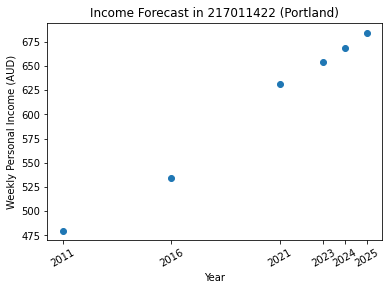

In [128]:
# visualise the prediction for presonal income of SA2code 217011422 (the last instance) as an example
x = [2011, 2016, 2021, 2023, 2024, 2025]
y = [income_pr[0][0], income_pr[1][0], income_pr[2][0]]
y.extend(future_pred_ip)

plt.scatter(x, y)
plt.xticks(x, rotation=30, fontsize=10)
plt.xlabel("Year")
plt.ylabel("Weekly Personal Income (AUD)")
plt.title("Income Forecast in 217011422 (Portland)")
plt.savefig("../plots/lm_forecast_example_217011422.png", bbox_inches="tight")

In [73]:
# again, but for 2016 and 2021 only
for i in range(df2.shape[0]):
    year = [[2016], [2021]]
    income_pr = [[df2.loc[i, "prsnl_income_2016"]], [df2.loc[i, "prsnl_income_2021"]]]
    income_fm = [[df2.loc[i, "fam_income_2016"]], [df2.loc[i, "fam_income_2021"]]]
    income_hd = [[df2.loc[i, "hhd_income_2016"]], [df2.loc[i, "hhd_income_2021"]]]
    rent = [[df2.loc[i, "rent_2016"]], [df2.loc[i, "rent_2021"]]]
    pop = [[df2.loc[i, "pop_2016"]], [df2.loc[i, "pop_2021"]]]

    reg.fit(year, income_pr)
    future_pred_ip = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, income_fm)
    future_pred_if = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, income_hd)
    future_pred_ih = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, rent)
    future_pred_r = reg.predict([[2023], [2024], [2025]])
    reg.fit(year, pop)
    future_pred_p = reg.predict([[2023], [2024], [2025]])

    # append to list (to which evantually going to be joined into a dataframe)
    year_list.extend([2023, 2024, 2025])
    SA2_code_list.extend([df2.loc[i, "SA2_code"], df2.loc[i, "SA2_code"], df2.loc[i, "SA2_code"]])
    # a bit tricky here, future_pred is 2-dimensional which needs to be flattened to a 1d list of length 3
    future_pred_ip = list(np.concatenate(future_pred_ip).flat)
    future_pred_if = list(np.concatenate(future_pred_if).flat)
    future_pred_ih = list(np.concatenate(future_pred_ih).flat)
    future_pred_r = list(np.concatenate(future_pred_r).flat)
    future_pred_p = list(np.concatenate(future_pred_p).flat)

    pred_income_prsnl.extend(future_pred_ip)
    pred_income_fam.extend(future_pred_if)
    pred_income_hhd.extend(future_pred_ih)
    pred_rent.extend(future_pred_r)
    pred_pop.extend(future_pred_p)

future_income_pop = pd.DataFrame({"Year": year_list, "SA2_codes": SA2_code_list, "pred_rent": pred_rent, \
    "pred_income_prsnl": pred_income_prsnl, "pred_income_fam": pred_income_fam, "pred_income_hhd": pred_income_hhd, "pred_pop": pred_pop})
future_income_pop

,Year,SA2_codes,pred_rent,pred_income_prsnl,pred_income_fam,pred_income_hhd,pred_pop
0,2023,201011001,394.000000,904.533333,2309.666667,2030.233333,14472.666667
1,2024,201011001,406.000000,930.133333,2369.666667,2084.933333,15135.666667
2,2025,201011001,418.000000,955.733333,2429.666667,2139.633333,15798.666667
3,2023,201011002,325.766667,882.566667,2397.433333,1657.100000,11145.333333
4,2024,201011002,334.066667,909.266667,2467.733333,1702.400000,11175.333333
...,...,...,...,...,...,...,...
1084,2024,217041479,330.000000,841.000000,2121.200000,1595.600000,19965.800000
1085,2025,217041479,340.000000,868.000000,2197.600000,1643.800000,20154.400000
1086,2023,217041480,301.800000,821.400000,2059.400000,1474.400000,12169.800000
1087,2024,217041480,309.200000,851.600000,2139.600000,1521.600000,12179.200000


In [74]:
# join this result with the crime forecast result
fdf = future_df.merge(future_income_pop, how="outer", on=["Year", "SA2_codes"]) \
    .sort_values(by=["Year", "SA2_codes"]) \
    .reset_index().drop(["index"], axis=1)
fdf

,Year,SA2_codes,pred_crime_count,pred_rent,pred_income_prsnl,pred_income_fam,pred_income_hhd,pred_pop
0,2023,201011001,NaN,394.000000,904.533333,2309.666667,2030.233333,14472.666667
1,2023,201011002,NaN,325.766667,882.566667,2397.433333,1657.100000,11145.333333
2,2023,201011005,NaN,349.333333,849.800000,2390.900000,2019.266667,6253.800000
3,2023,201011006,NaN,388.266667,810.333333,1945.366667,1712.533333,9469.900000
4,2023,201011007,NaN,352.333333,836.166667,2367.133333,2172.733333,3540.400000
...,...,...,...,...,...,...,...,...
1210,2025,217031476,NaN,317.000000,782.600000,1775.600000,1351.800000,4358.200000
1211,2025,217041477,NaN,240.000000,893.800000,2243.400000,1755.400000,6439.400000
1212,2025,217041478,NaN,325.600000,870.800000,2263.800000,1766.000000,9291.000000
1213,2025,217041479,NaN,340.000000,868.000000,2197.600000,1643.800000,20154.400000


In [75]:
# impute missing values for every column by mean per year
for col in range(fdf.shape[1]):
    # get column name
    colname = fdf.columns[col]
    if (colname == "Year") or (colname == "SA2_codes"):
        continue

    # drop null values to find the mean to be imputed to those nulls
    pred_2023 = fdf.loc[fdf["Year"] == 2023][colname].dropna().to_numpy()
    pred_2024 = fdf.loc[fdf["Year"] == 2024][colname].dropna().to_numpy()
    pred_2025 = fdf.loc[fdf["Year"] == 2025][colname].dropna().to_numpy()
    mean_2023 = np.mean(pred_2023)
    mean_2024 = np.mean(pred_2024)
    mean_2025 = np.mean(pred_2025)

    # impute
    for i in range(fdf.shape[0]):
        if np.isnan(fdf.loc[i, colname]):
            if fdf.loc[i, "Year"] == 2023:
                fdf.loc[i, colname] = mean_2023
            elif fdf.loc[i, "Year"] == 2024:
                fdf.loc[i, colname] = mean_2024
            else:
                fdf.loc[i, colname] = mean_2025

fdf

,Year,SA2_codes,pred_crime_count,pred_rent,pred_income_prsnl,pred_income_fam,pred_income_hhd,pred_pop
0,2023,201011001,941.366206,394.000000,904.533333,2309.666667,2030.233333,14472.666667
1,2023,201011002,941.366206,325.766667,882.566667,2397.433333,1657.100000,11145.333333
2,2023,201011005,941.366206,349.333333,849.800000,2390.900000,2019.266667,6253.800000
3,2023,201011006,941.366206,388.266667,810.333333,1945.366667,1712.533333,9469.900000
4,2023,201011007,941.366206,352.333333,836.166667,2367.133333,2172.733333,3540.400000
...,...,...,...,...,...,...,...,...
1210,2025,217031476,995.210388,317.000000,782.600000,1775.600000,1351.800000,4358.200000
1211,2025,217041477,995.210388,240.000000,893.800000,2243.400000,1755.400000,6439.400000
1212,2025,217041478,995.210388,325.600000,870.800000,2263.800000,1766.000000,9291.000000
1213,2025,217041479,995.210388,340.000000,868.000000,2197.600000,1643.800000,20154.400000


In [76]:
# all values are now non-null
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               1215 non-null   int64  
 1   SA2_codes          1215 non-null   object 
 2   pred_crime_count   1215 non-null   float64
 3   pred_rent          1215 non-null   float64
 4   pred_income_prsnl  1215 non-null   float64
 5   pred_income_fam    1215 non-null   float64
 6   pred_income_hhd    1215 non-null   float64
 7   pred_pop           1215 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 76.1+ KB


## join with sa2codes from full data

In [77]:
prop = pd.read_csv("../data/curated/full_data.csv")
fdf2 = pd.DataFrame({"SA2_codes": prop["SA2_CODE_2021"].unique().astype(int).astype(str)})

fdf3 = fdf2.merge(fdf, on="SA2_codes", how="left")
fdf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 690
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SA2_codes          691 non-null    object 
 1   Year               657 non-null    float64
 2   pred_crime_count   657 non-null    float64
 3   pred_rent          657 non-null    float64
 4   pred_income_prsnl  657 non-null    float64
 5   pred_income_fam    657 non-null    float64
 6   pred_income_hhd    657 non-null    float64
 7   pred_pop           657 non-null    float64
dtypes: float64(7), object(1)
memory usage: 48.6+ KB


In [78]:
SA2_full = fdf["SA2_codes"].tolist()
year = fdf["Year"].tolist()
means = []  # the means of each six feature predictions

for col in range(fdf.shape[1]):
    # get column name
    colname = fdf.columns[col]
    if (colname == "Year") or (colname == "SA2_codes"):
        continue

    # get means
    pred_2023 = fdf.loc[fdf["Year"] == 2023][colname].to_numpy()
    pred_2024 = fdf.loc[fdf["Year"] == 2024][colname].to_numpy()
    pred_2025 = fdf.loc[fdf["Year"] == 2025][colname].to_numpy()
    mean_2023 = np.mean(pred_2023)
    mean_2024 = np.mean(pred_2024)
    mean_2025 = np.mean(pred_2025)
    means.extend([mean_2023, mean_2024, mean_2025])
means

[941.3662064431288,
 968.2882971729117,
 995.2103879026945,
 375.703489439853,
 385.433792470156,
 395.1640955004591,
 828.8858585858583,
 853.565472910927,
 878.2450872359962,
 2221.68466483012,
 2289.311662075299,
 2356.938659320478,
 1834.2342516069784,
 1887.7965105601465,
 1941.358769513314,
 11633.634343434345,
 11796.779797979798,
 11959.925252525258]

In [79]:
SA2_na = fdf3[fdf3["Year"].isna()]["SA2_codes"]
pred_crime_count = fdf["pred_crime_count"].tolist()	
pred_rent = fdf["pred_rent"].tolist()
pred_income_prsnl = fdf["pred_income_prsnl"].tolist()	
pred_income_fam = fdf["pred_income_fam"].tolist()	
pred_income_hhd = fdf["pred_income_hhd"].tolist()	
pred_pop = fdf["pred_pop"].tolist()

NUM_YEARS = 3

for i in SA2_na:
    count = 0
    while count < NUM_YEARS:
        SA2_full.append(i)
        
        if count == 0:
            year.append(2023)
        elif count == 1:
            year.append(2024)
        else:
            year.append(2025)
        
        pred_crime_count.append(means[count % NUM_YEARS])
        pred_rent.append(means[(count % NUM_YEARS) + NUM_YEARS])
        pred_income_prsnl.append(means[(count % NUM_YEARS) + NUM_YEARS*2])
        pred_income_fam.append(means[(count % NUM_YEARS) + NUM_YEARS*3])
        pred_income_hhd.append(means[(count % NUM_YEARS) + NUM_YEARS*4])
        pred_pop.append(means[(count % NUM_YEARS) + NUM_YEARS*5])

        count += 1

df = pd.DataFrame({"Year": year, "SA2_codes": SA2_full, "pred_rent": pred_rent, "pred_crime_count": pred_crime_count, \
    "pred_income_prsnl": pred_income_prsnl, "pred_income_fam": pred_income_fam, "pred_income_hhd": pred_income_hhd, "pred_pop": pred_pop})

df

,Year,SA2_codes,pred_rent,pred_crime_count,pred_income_prsnl,pred_income_fam,pred_income_hhd,pred_pop
0,2023,201011001,394.000000,941.366206,904.533333,2309.666667,2030.233333,14472.666667
1,2023,201011002,325.766667,941.366206,882.566667,2397.433333,1657.100000,11145.333333
2,2023,201011005,349.333333,941.366206,849.800000,2390.900000,2019.266667,6253.800000
3,2023,201011006,388.266667,941.366206,810.333333,1945.366667,1712.533333,9469.900000
4,2023,201011007,352.333333,941.366206,836.166667,2367.133333,2172.733333,3540.400000
...,...,...,...,...,...,...,...,...
1312,2024,212041564,385.433792,968.288297,853.565473,2289.311662,1887.796511,11796.779798
1313,2025,212041564,395.164096,995.210388,878.245087,2356.938659,1941.358770,11959.925253
1314,2023,213051587,375.703489,941.366206,828.885859,2221.684665,1834.234252,11633.634343
1315,2024,213051587,385.433792,968.288297,853.565473,2289.311662,1887.796511,11796.779798


In [80]:
# might need to round some values (like population) to the nearest integer, because 
# right now some values don't really make sense if they are not integers
fdf.to_csv("../data/curated/forecast_data.csv")